# Regression Task

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [52]:
df = pd.read_csv('/content/drive/MyDrive/AI Coursework/insurance.csv')

##Data Understanding and Exploratory Data Analysis

In [53]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [54]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [55]:
#identify the number of rows and columns in the dataset.

rows, cols = df.shape

print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 1338, Number of columns: 7


In [56]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [57]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [100]:
#check for duplicate values
print(f"Total number of duplicated values in the dataset: {df.duplicated().sum()}")

Total number of duplicated values in the dataset: 1


In [101]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Verify if duplicates are removed
print(f"Total number of duplicated values in the dataset after dropping duplicates: {df.duplicated().sum()}")


Total number of duplicated values in the dataset after dropping duplicates: 0


In [59]:
# Check for missing values
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [60]:
# Select all categorical columns (columns with data type 'object') from the DataFrame
categoricalCol = df.select_dtypes(include='object')

# Select all numerical columns (columns with data type 'number') from the DataFrame
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns


##Visualization

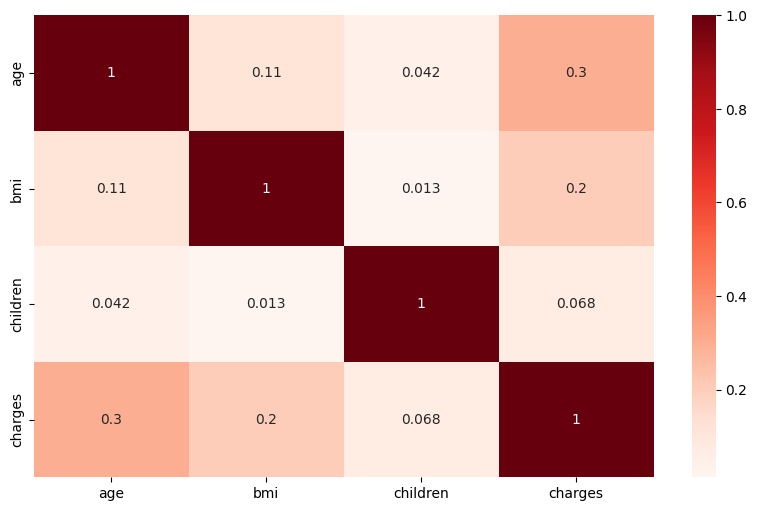

In [61]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='Reds')
plt.show()

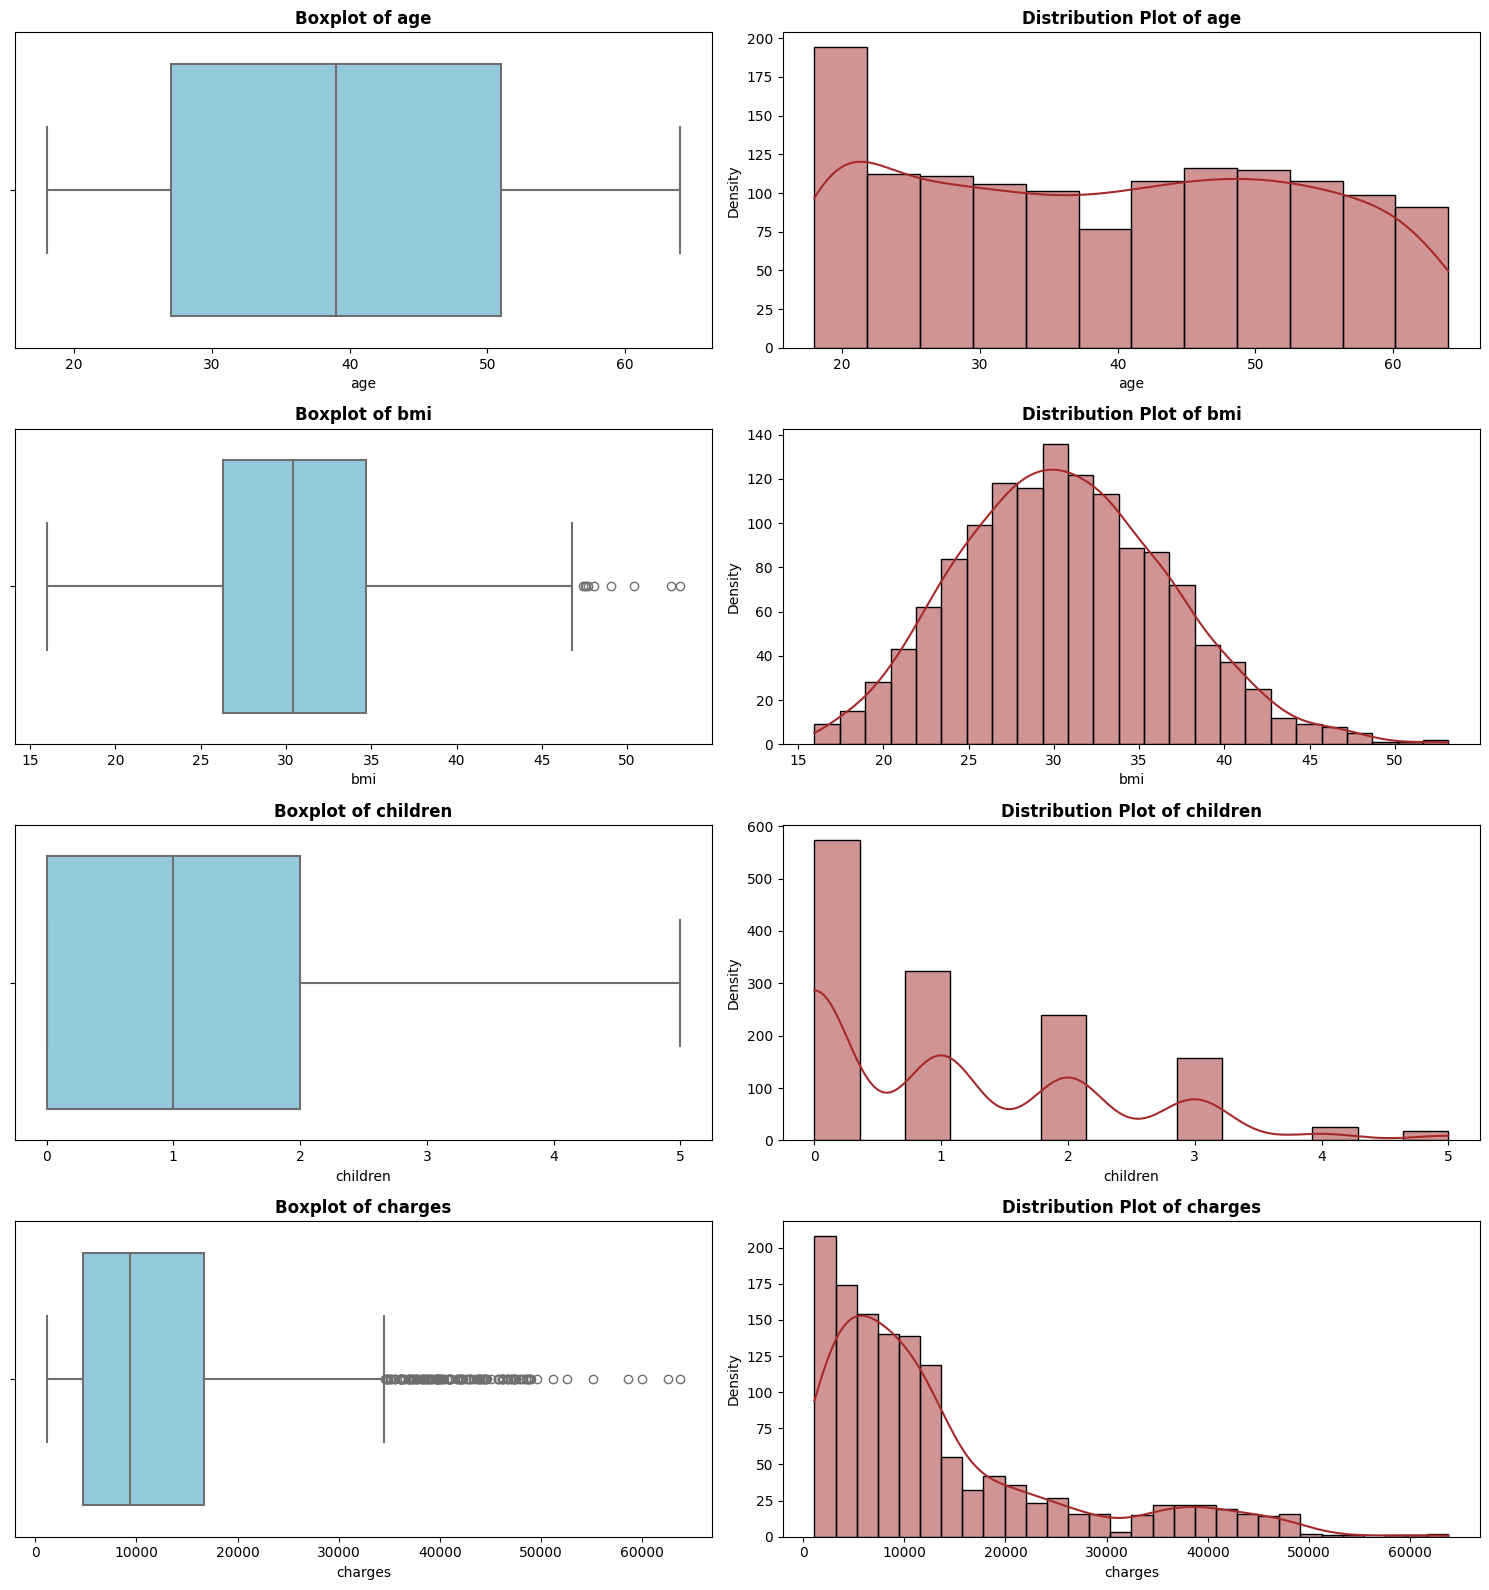

In [62]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, len(numerical_columns)*4))

for i, col in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 2, 2 * i + 1)
    sns.boxplot(x=df[col], orient='h', color="skyblue", linewidth=1.5)
    plt.title(f"Boxplot of {col}", fontsize=12, fontweight="bold")
    plt.xlabel(col, fontsize=10)

    plt.subplot(len(numerical_columns), 2, 2 * i + 2)
    sns.histplot(df[col], kde=True, color="brown", linewidth=1)
    plt.title(f"Distribution Plot of {col}", fontsize=12, fontweight="bold")
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Density", fontsize=10)

plt.tight_layout()
plt.show()

##Label Encoding

In [63]:
#encoding categorical values
label_encoder = LabelEncoder()
df['region'] = label_encoder.fit_transform(df['region'])
df['sex'] = label_encoder.fit_transform(df['sex'])
df['smoker'] = label_encoder.fit_transform(df['smoker'])

In [64]:
#Handling outliers
def wisker(col):
    q1, q3 = np.percentile(col, [25, 75])  # Calculate the 25th (Q1) and 75th (Q3) percentiles
    iqr = q3 - q1  # Calculate the interquartile range (IQR)
    lw = q1 - 1.5 * iqr  # Calculate lower whisker (Q1 - 1.5 * IQR)
    uw = q3 + 1.5 * iqr  # Calculate upper whisker (Q3 + 1.5 * IQR)
    return lw, uw  # Return the lower and upper whiskers

for i in ['bmi', 'charges']:
    # Corrected column name: added an extra space before '1-19'
    lw, uw = wisker(df[i])  # Calculate whiskers for each column
    df[i] = np.where(df[i] < lw, lw, df[i])  # Replace values below the lower whisker with the lower whisker
    df[i] = np.where(df[i] > uw, uw, df[i])  # Replace values above the upper whisker with the upper whisker

In [65]:
print("Columns:")
print(df.columns)


Columns:
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


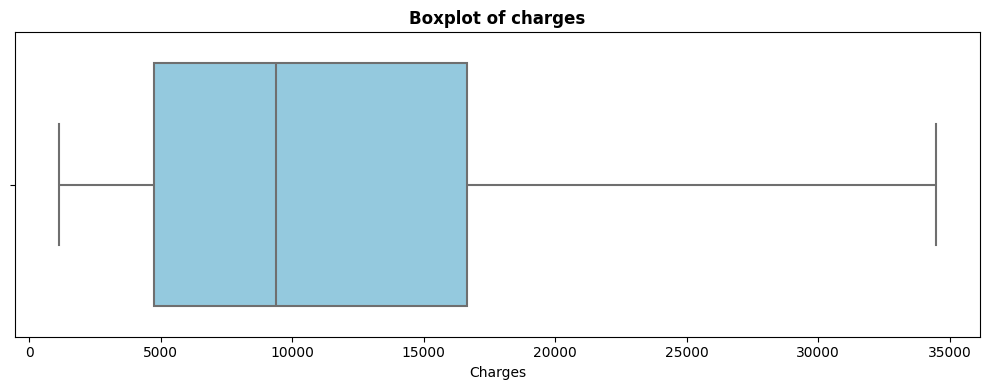

In [66]:
#boxplot after handling outlier
plt.figure(figsize=(10, 4))

sns.boxplot(x=df['charges'], orient='h', color="skyblue", linewidth=1.5)

plt.title(f"Boxplot of charges", fontsize=12, fontweight="bold")
plt.xlabel("Charges", fontsize=10)

plt.tight_layout()
plt.show()


##Data standarization


In [67]:
#Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[["age", "charges"]])
print("Scaled Data:", scaled_data)

Scaled Data: [[-1.43876426  0.43386273]
 [-1.50996545 -1.05904493]
 [-0.79795355 -0.79079201]
 ...
 [-1.50996545 -1.0684714 ]
 [-1.29636188 -1.03123466]
 [ 1.55168573  1.64088688]]


In [68]:
#After scaling replacing/updating those scaled datas in the dataset
df[["age_scaled", "charges_scaled"]] = scaled_data
df = df.drop(columns=["age", "charges"])
print("Updated DataFrame:")
df.head()

Updated DataFrame:


,sex,bmi,children,smoker,region,age_scaled,charges_scaled
0,0,27.900,0,1,3,-1.438764,0.433863
1,1,33.770,1,0,2,-1.509965,-1.059045
2,1,33.000,3,0,2,-0.797954,-0.790792
3,1,22.705,0,0,1,-0.441948,0.936070
4,1,28.880,0,0,1,-0.513149,-0.848168


In [69]:
#One-Hot encoding
df = pd.get_dummies(df, columns=['region'], drop_first=False)
df

,sex,bmi,children,smoker,age_scaled,charges_scaled,region_0,region_1,region_2,region_3
0,0,27.900,0,1,-1.438764,0.433863,False,False,False,True
1,1,33.770,1,0,-1.509965,-1.059045,False,False,True,False
2,1,33.000,3,0,-0.797954,-0.790792,False,False,True,False
3,1,22.705,0,0,-0.441948,0.936070,False,True,False,False
4,1,28.880,0,0,-0.513149,-0.848168,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
1333,1,30.970,3,0,0.768473,-0.185028,False,True,False,False
1334,0,31.920,0,0,-1.509965,-1.011732,True,False,False,False
1335,0,36.850,0,0,-1.509965,-1.068471,False,False,True,False
1336,0,25.800,0,0,-1.296362,-1.031235,False,False,False,True


##Splitting Dataset into training and testing sets.

In [70]:
X=df.drop(['charges_scaled'],axis=1)
y=df['charges_scaled']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##Model From Scratch

In [73]:
class LinearRegressionScratch:
    def __init__(self, alpha=0.0005, n_iter=5000):
        self.alpha = alpha
        self.n_iter = n_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        """Train using gradient descent."""
        m, n = X.shape
        self.w = np.random.randn(n) * 0.01  # Small random initialization
        self.b = 0.0

        for i in range(self.n_iter):
            y_pred = X.dot(self.w) + self.b
            error = y_pred - y

            # Compute gradients
            dw = (1 / m) * X.T.dot(error)
            db = (1 / m) * np.sum(error)

            # Update parameters
            self.w -= self.alpha * dw
            self.b -= self.alpha * db

            # Debug every 500 iterations
            if i % 500 == 0:
                cost = (1 / (2 * m)) * np.sum(error ** 2)
                print(f"Iteration {i}, Cost: {cost:.5f}, b: {self.b:.5f}")

    def predict(self, X):
        """Make predictions."""
        return X.dot(self.w) + self.b


In [74]:
# Train model
lr_model = LinearRegressionScratch()
lr_model.fit(X_train_scaled, y_train)

Iteration 0, Cost: 0.48784, b: 0.00000
Iteration 500, Cost: 0.34770, b: 0.00191
Iteration 1000, Cost: 0.26291, b: 0.00339
Iteration 1500, Cost: 0.21135, b: 0.00455
Iteration 2000, Cost: 0.17987, b: 0.00545
Iteration 2500, Cost: 0.16056, b: 0.00615
Iteration 3000, Cost: 0.14869, b: 0.00670
Iteration 3500, Cost: 0.14137, b: 0.00712
Iteration 4000, Cost: 0.13684, b: 0.00745
Iteration 4500, Cost: 0.13403, b: 0.00771


In [75]:
# Predict
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

In [76]:
# Evaluate
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}")
print(f"Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")

Train MSE: 0.265, Test MSE: 0.239
Train R²: 0.732, Test R²: 0.773


#Building Primary Model

##Model 1:  Linear Regression

In [77]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [78]:
y_predtest = model.predict(X_test)
y_predtrain = model.predict(X_train)

In [79]:
"""Calculate Mean Squared Error, Root Mean Squared Error and R-squared Error
for the training set"""

mse = mean_squared_error(y_train, y_predtrain)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_predtrain)
print("Linear Regression model:")
print(f'For Training set:\nMean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R²): {r2:.4f}')


Linear Regression model:
For Training set:
Mean Squared Error (MSE): 0.2588
Root Mean Squared Error (RMSE): 0.5087
R-squared (R²): 0.7376


In [80]:
"""Calculate Mean Squared Error, Root Mean Squared Error and R-squared Error
for the test set"""

mse = mean_squared_error(y_test, y_predtest)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predtest)
print("Linear Regression model:")
print(f'Test:\nMean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R²): {r2:.4f}')

Linear Regression model:
Test:
Mean Squared Error (MSE): 0.2273
Root Mean Squared Error (RMSE): 0.4768
R-squared (R²): 0.7841


##Model 2: Random Forest Regressor

In [81]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)  # Train the model

RandomForestRegressor(random_state=42)

In [82]:
y_predtest_rf = rf_reg.predict(X_test)
y_predtrain_rf = rf_reg.predict(X_train)

In [83]:
mae_rf = mean_absolute_error(y_train, y_predtrain_rf)
mse_rf = mean_squared_error(y_train, y_predtrain_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_train, y_predtrain_rf)


In [84]:
print("\nRandom Forest Regressor Performance on Training Set:")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R-squared: {r2_rf:.4f}")


Random Forest Regressor Performance on Training Set:
MAE: 0.0937
MSE: 0.0324
RMSE: 0.1800
R-squared: 0.9672


In [85]:
mae_rf = mean_absolute_error(y_test, y_predtest_rf)
mse_rf = mean_squared_error(y_test, y_predtest_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_predtest_rf)

In [86]:
print("\nRandom Forest Regressor Performance on Test:")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R-squared: {r2_rf:.4f}")


Random Forest Regressor Performance on Test:
MAE: 0.2173
MSE: 0.1760
RMSE: 0.4196
R-squared: 0.8328


####The Random Forest Regressor performed better than Linear Regression on the test set. The Random Forest model achieved a lower MSE (0.1760), lower RMSE (0.4196), and a higher R-squared (0.8328) compared to the Linear Regression model with an R-squared of 0.7841. Additionally, the MAE (0.2173) for Random Forest is slightly better than the Linear Regression's performance on the training set. This suggests that Random Forest provides more accurate predictions and better generalization to unseen data.

#Hyperparameter Optimization

##Hyperparameter Optimization: Linear Regression

In [87]:
#Hyperparameter Tuning: Linear Regression (Ridge)
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Regularization strength
ridge = Ridge()

In [88]:
grid_ridge = GridSearchCV(ridge, ridge_params, scoring='r2', cv=5)
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]}, scoring='r2')

In [89]:
best_ridge = grid_ridge.best_estimator_
print("\nBest Linear Regression Hyperparameters:", grid_ridge.best_params_)


Best Linear Regression Hyperparameters: {'alpha': 1}


##Hyperparameter Optimization: Random Forest Regressor

In [90]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, scoring='r2', cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [91]:
best_rf = grid_rf.best_estimator_
print("\nBest Random Forest Hyperparameters:", grid_rf.best_params_)


Best Random Forest Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


#Feature selection

##Feature Selection: Linear Regression

In [92]:
# Feature Selection: Ridge Regression (RFE)
rfe_selector = RFE(best_ridge, n_features_to_select=5)  # Select top 5 features
rfe_selector.fit(X_train, y_train)

# Get selected features
selected_features_ridge = X_train.columns[rfe_selector.support_].tolist()
print("\nSelected Features for Ridge Regression:", selected_features_ridge)



Selected Features for Ridge Regression: ['children', 'smoker', 'age_scaled', 'region_0', 'region_2']


##Feature Selection: Random Forest Regressor

In [93]:
#Feature Selection: Random Forest (Feature Importance)
feature_importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
selected_features_rf = feature_importance_df.nlargest(5, 'Importance')['Feature'].tolist()  # Top 5

print("\nSelected Features for Random Forest:", selected_features_rf)


Selected Features for Random Forest: ['smoker', 'age_scaled', 'bmi', 'children', 'region_0']


#Final Model(Random Forest Regressor) After Hyperparameter Optimization and Hyperparameter Tuning

In [94]:
X_train_rf = X_train[selected_features_rf]
X_test_rf = X_test[selected_features_rf]

In [95]:
final_rf = RandomForestRegressor(**grid_rf.best_params_, random_state=42)
final_rf.fit(X_train_rf, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

In [96]:
y_predtest_rf_final = final_rf.predict(X_test_rf)
y_predtrain_rf_final = final_rf.predict(X_train_rf)

In [97]:
mae_rf_train_final = mean_absolute_error(y_train, y_predtrain_rf_final)
mse_rf_train_final = mean_squared_error(y_train, y_predtrain_rf_final)
rmse_rf_train_final = np.sqrt(mse_rf)
r2_rf_train_final = r2_score(y_train, y_predtrain_rf_final)

print("\nFinal Random Forest Performance for Train set:")
print(f"MAE: {mae_rf_train_final:.4f}")
print(f"MSE: {mse_rf_train_final:.4f}")
print(f"RMSE: {rmse_rf_train_final:.4f}")
print(f"R-squared: {r2_rf_train_final:.4f}")


Final Random Forest Performance for Train set:
MAE: 0.1788
MSE: 0.1179
RMSE: 0.4196
R-squared: 0.8805


In [98]:
mae_rf_test_final = mean_absolute_error(y_test, y_predtest_rf_final)
mse_rf_test_final = mean_squared_error(y_test, y_predtest_rf_final)
rmse_rf_test_final = np.sqrt(mse_rf_test_final)
r2_rf_test_final = r2_score(y_test, y_predtest_rf_final)

print("\nFinal Random Forest Performance for Test set:")
print(f"MAE: {mae_rf_test_final:.4f}")
print(f"MSE: {mse_rf_test_final:.4f}")
print(f"RMSE: {rmse_rf_test_final:.4f}")
print(f"R-squared: {r2_rf_test_final:.4f}")



Final Random Forest Performance for Test set:
MAE: 0.2077
MSE: 0.1654
RMSE: 0.4067
R-squared: 0.8429


#Conclusion:

Initial Random Forest Model demonstrates stronger fit to training data and higher R-squared values on both training and test sets, suggesting it may be overfitting while the final model (after hyperparameter tuning and feature selection) sacrifices some performance on the training set in exchange for a slightly better generalization to the test data, as seen in the test R-squared. This indicates that final model is more robust and better suited for unseen data, though with a slight loss in overall accuracy.